# Semantic Analysis

### Useful imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd

#NLP libraries
import nltk, gensim
import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Lexicon

In [2]:
from empath import Empath
lexicon = Empath()

#### Inspect available lexicon categories

In [3]:
lexicon.cats.keys()

dict_keys(['help', 'office', 'dance', 'money', 'wedding', 'domestic_work', 'sleep', 'medical_emergency', 'cold', 'hate', 'cheerfulness', 'aggression', 'occupation', 'envy', 'anticipation', 'family', 'vacation', 'crime', 'attractive', 'masculine', 'prison', 'health', 'pride', 'dispute', 'nervousness', 'government', 'weakness', 'horror', 'swearing_terms', 'leisure', 'suffering', 'royalty', 'wealthy', 'tourism', 'furniture', 'school', 'magic', 'beach', 'journalism', 'morning', 'banking', 'social_media', 'exercise', 'night', 'kill', 'blue_collar_job', 'art', 'ridicule', 'play', 'computer', 'college', 'optimism', 'stealing', 'real_estate', 'home', 'divine', 'sexual', 'fear', 'irritability', 'superhero', 'business', 'driving', 'pet', 'childish', 'cooking', 'exasperation', 'religion', 'hipster', 'internet', 'surprise', 'reading', 'worship', 'leader', 'independence', 'movement', 'body', 'noise', 'eating', 'medieval', 'zest', 'confusion', 'water', 'sports', 'death', 'healing', 'legend', 'heroic

#### Create missing interesting categories

In [4]:
lexicon.create_category('cinema_television', ['cinema', 'movies', 'tv', 'television', 'tv_show', 'film', 'blockbuster'], model='nytimes')

["movies", "film", "movie", "films", "cinema", "American_movies", "old_movies", "documentaries", "mini-series", "Hollywood", "big_screen", "soap_operas", "animation", "American_television", "television_shows", "dramas", "television", "home_video", "music_videos", "small_screen", "sitcoms", "movie_industry", "comedies", "special_effects", "Hollywood_movies", "Mr._Spielberg", "feature_film", "motion_pictures", "Hollywood_films", "motion_picture", "westerns", "television_series", "film_makers", "Matrix", "filmmakers", "independent_films", "filmmaking", "independent_film", "genre", "reality_television", "music_video", "comics", "British_television", "American_films", "film_industry", "other_films", "MTV", "feature_films", "filmmaking", "foreign_films", "Pulp_Fiction", "filmmaker", "action_films", "television_drama", "American_audiences", "sequels", "film_maker", "other_movies", "documentary", "new_film", "Fellini", "Mr._Scorsese", "theatrical_release", "Sundance", "moviegoers", "television

In [5]:
# lexicon.create_category('technology', ['technology', 'tech'], model='nytimes')

In [6]:
lexicon.create_category('fiction', ['fiction', 'fantasy_world', 'magic', 'superhero', 'monster'], model='reddit')

["fantasy_world", "superhero", "fictional_world", "fictional", "magic", "fantasy_story", "psychic_powers", "magic", "fiction", "fictional_character", "fantasy", "fictional_universe", "super_hero", "protagonist", "super_powers", "fantasy_worlds", "superpowers", "magic_powers", "villain", "supervillain", "Harry_Potter_universe", "common_trope", "supernatural_powers", "vampires", "superheroes", "mythos", "dystopian_future", "actual_magic", "fictional_story", "fairy_tale", "main_character", "magical_powers", "trope", "mcguffin", "supernatural_creatures", "comic_book", "villian", "fictionally", "fictional_characters", "own_imagination", "antagonist", "fantasy_character", "alternate_reality", "fictional_work", "own_world", "fantasy_novel", "alternate_world", "vampire", "sci-fi_world", "ultimate_evil", "lead_character", "protag", "fantasy_universe", "main_protagonist", "imaginary_world", "magical_world", "supernatural_stuff", "central_character", "fantastical", "super_villain", "fictional_set

We select the interesting categories:

In [7]:
interesting_categories=['money', 'health', 'government', 'leisure', 'technology', 'cinema_television', 
                        'tourism', 'journalism', 'banking', 'social_media', 'art', 'computer', 'real_estate', 
                        'home', 'sexual', 'fiction', 'business', 'cooking', 'religion', 'internet', 'eating', 
                        'sports', 'love', 'weather', 'music', 'vehicle', 'science', 'work', 'fun', 'traveling', 
                        'fashion', 'economics', 'politics', 'philosophy', 'law', 'feminine', 'beauty']

### Load data

In [8]:
CLEAN_QUOTES = '../data/clean_quotes.csv.bz2'
CLUSTERS = '../data/clusters.csv.bz2'
QUOTES_PATH = '../data/quotes-2020.json.bz2'

In [9]:
clean_quotes = pd.read_csv(CLEAN_QUOTES).drop_duplicates()[['quoteID', 'journal']]
clean_quotes.head(1)

,quoteID,journal
0,2020-01-24-000168,people.com


In [10]:
cluster_assignments = pd.read_csv(CLUSTERS, index_col=0)['cluster_id']
# dictionary {journal_name -> cluster_id}
cluster_dict = dict(cluster_assignments)
cluster_assignments.head(2)

journal
1011now.com      -1.0
1070thefan.com   -1.0
Name: cluster_id, dtype: float64

In [11]:
# Clusters
print(cluster_assignments.unique())
n_clusters = len(cluster_assignments.unique()) - 1 # ignore noise cluster (-1 assignemnt)
print(f'Number of clusters: {n_clusters}')

[-1.  6. 14.  7. 12.  3.  8.  4.  9. 10.  2. 11. 13.  1.  5.  0.]
Number of clusters: 15


Text(0.5, 0, 'Cluster label/ID')

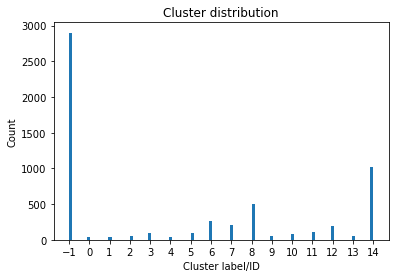

In [12]:
plt.hist(cluster_assignments, bins=100)
plt.xticks(range(-1, n_clusters))
plt.title('Cluster distribution')
plt.ylabel('Count')
plt.xlabel('Cluster label/ID')

In [13]:
quotes = []

def process_chunk(chunk):
        print(f'Processing chunk')
        quotes.append(chunk[['quoteID', 'quotation']])      

with pd.read_json(QUOTES_PATH, lines=True, compression='bz2', chunksize=1000000) as df_reader:
    for chunk in df_reader:
        process_chunk(chunk)
        
quotes = pd.concat(quotes)

Processing chunk
Processing chunk
Processing chunk
Processing chunk
Processing chunk
Processing chunk


In [14]:
# Create dictionary {quoteID -> quotation}
quotes_dict = dict(quotes.values)

#### Semantic analysis

In [15]:
# Group quote IDs by journal
by_journal = clean_quotes.groupby('journal')

In [16]:
journal_stats = []
for i, journal in enumerate(by_journal.groups.keys()):
    # Fetch i-th journal quote IDs
    jrnl_quotes = by_journal.get_group(journal)
    # Use the {ID -> quote} dict to obtain quotations
    qs = [quotes_dict[q] for q in jrnl_quotes.quoteID.values]
    # Join all quotes to perform semantic analysis in one go on all quotations
    qs = '\n'.join(qs)
    # Semantic analysis
    q_stats = lexicon.analyze(qs, categories=interesting_categories, normalize=True)
    # Add to list which will be converted into a dataframe at the end (computationally faster)
    journal_stats.append(pd.DataFrame(q_stats, index=[journal]))
    # Print progress (5734 total journals)
    print(f'Journal {i}/5734 :  {journal}')

Journal 0/5734 :  1011now.com
Journal 1/5734 :  1070thefan.com
Journal 2/5734 :  107jamz.com
Journal 3/5734 :  10news.com
Journal 4/5734 :  1130thetiger.com
Journal 5/5734 :  13abc.com
Journal 6/5734 :  1428elm.com
Journal 7/5734 :  14news.com
Journal 8/5734 :  15rounds.com
Journal 9/5734 :  1888pressrelease.com
Journal 10/5734 :  220triathlon.com
Journal 11/5734 :  225batonrouge.com
Journal 12/5734 :  247sports.com
Journal 13/5734 :  247wallst.com
Journal 14/5734 :  24hourhiphop.com
Journal 15/5734 :  2oceansvibe.com
Journal 16/5734 :  2paragraphs.com
Journal 17/5734 :  303magazine.com
Journal 18/5734 :  360nobs.com
Journal 19/5734 :  3aw.com.au
Journal 20/5734 :  3blmedia.com
Journal 21/5734 :  3dprint.com
Journal 22/5734 :  411mania.com
Journal 23/5734 :  41nbc.com
Journal 24/5734 :  49ers.com
Journal 25/5734 :  4bc.com.au
Journal 26/5734 :  4ni.co.uk
Journal 27/5734 :  5280.com
Journal 28/5734 :  570news.com
Journal 29/5734 :  604now.com
Journal 30/5734 :  620ckrm.com
Journal 31/57

Journal 254/5734 :  artnet.com
Journal 255/5734 :  artnews.com
Journal 256/5734 :  artshub.com.au
Journal 257/5734 :  artvoice.com
Journal 258/5734 :  arynews.tv
Journal 259/5734 :  aseaofblue.com
Journal 260/5734 :  asianage.com
Journal 261/5734 :  asianimage.co.uk
Journal 262/5734 :  asianjournal.com
Journal 263/5734 :  asianpacificpost.com
Journal 264/5734 :  asianscientist.com
Journal 265/5734 :  asiantribune.com
Journal 266/5734 :  asiaone.com
Journal 267/5734 :  asiapacificreport.nz
Journal 268/5734 :  asiasentinel.com
Journal 269/5734 :  asiatraveltips.com
Journal 270/5734 :  askmen.com
Journal 271/5734 :  aspendailynews.com
Journal 272/5734 :  aspenjournalism.org
Journal 273/5734 :  aspentimes.com
Journal 274/5734 :  assetservicingtimes.com
Journal 275/5734 :  assignmentx.com
Journal 276/5734 :  associationsnow.com
Journal 277/5734 :  astroawani.com
Journal 278/5734 :  astrobiology.com
Journal 279/5734 :  astronomy.com
Journal 280/5734 :  astronomynow.com
Journal 281/5734 :  as

Journal 488/5734 :  birminghammail.co.uk
Journal 489/5734 :  birminghamtimes.com
Journal 490/5734 :  bitcoin.com
Journal 491/5734 :  bitcoinmagazine.com
Journal 492/5734 :  biv.com
Journal 493/5734 :  bizcommunity.com
Journal 494/5734 :  bizedge.co.nz
Journal 495/5734 :  bizpacreview.com
Journal 496/5734 :  bizwest.com
Journal 497/5734 :  bjpenn.com
Journal 498/5734 :  bkreader.com
Journal 499/5734 :  blabbermouth.net
Journal 500/5734 :  blackagendareport.com
Journal 501/5734 :  blackandteal.com
Journal 502/5734 :  blackburnnews.com
Journal 503/5734 :  blackenterprise.com
Journal 504/5734 :  blackhillsfox.com
Journal 505/5734 :  blacknews.com
Journal 506/5734 :  blackpoolgazette.co.uk
Journal 507/5734 :  blackshoediaries.com
Journal 508/5734 :  blackstarnews.com
Journal 509/5734 :  blacktownsun.com.au
Journal 510/5734 :  blackwhitereadallover.com
Journal 511/5734 :  blastingnews.com
Journal 512/5734 :  blastr.com
Journal 513/5734 :  blayneychronicle.com.au
Journal 514/5734 :  blazersed

Journal 703/5734 :  businesstraveller.com
Journal 704/5734 :  businesstravelnews.com
Journal 705/5734 :  businessweek.com
Journal 706/5734 :  businesswest.com
Journal 707/5734 :  businesswire.com
Journal 708/5734 :  businessworld.ie
Journal 709/5734 :  businessworld.in
Journal 710/5734 :  busiweek.com
Journal 711/5734 :  busseltonmail.com.au
Journal 712/5734 :  bustle.com
Journal 713/5734 :  buxtonadvertiser.co.uk
Journal 714/5734 :  buyingbusinesstravel.com
Journal 715/5734 :  buzzfeed.com
Journal 716/5734 :  bwog.com
Journal 717/5734 :  bworldonline.com
Journal 718/5734 :  byronnews.com.au
Journal 719/5734 :  byu.edu
Journal 720/5734 :  byuiscroll.org
Journal 721/5734 :  c-ville.com
Journal 722/5734 :  c21media.net
Journal 723/5734 :  cachevalleydaily.com
Journal 724/5734 :  cafemom.com
Journal 725/5734 :  cagesideseats.com
Journal 726/5734 :  cagw.org
Journal 727/5734 :  cairnspost.com.au
Journal 728/5734 :  calbears.com
Journal 729/5734 :  calcoastnews.com
Journal 730/5734 :  calga

Journal 923/5734 :  chron.com
Journal 924/5734 :  chroniclejournal.com
Journal 925/5734 :  chroniclelive.co.uk
Journal 926/5734 :  chronicletimes.com
Journal 927/5734 :  chronogram.com
Journal 928/5734 :  churchmilitant.com
Journal 929/5734 :  churchtimes.co.uk
Journal 930/5734 :  cilisos.my
Journal 931/5734 :  cimsec.org
Journal 932/5734 :  cincyjungle.com
Journal 933/5734 :  cinelinx.com
Journal 934/5734 :  cinemablend.com
Journal 935/5734 :  cio.com
Journal 936/5734 :  ciol.com
Journal 937/5734 :  circleid.com
Journal 938/5734 :  cis.org
Journal 939/5734 :  citiblog.co.uk
Journal 940/5734 :  citizen.co.za
Journal 941/5734 :  citizen.on.ca
Journal 942/5734 :  citizenmatters.in
Journal 943/5734 :  citizentv.co.ke
Journal 944/5734 :  city-journal.org
Journal 945/5734 :  cityam.com
Journal 946/5734 :  citybeat.com
Journal 947/5734 :  citylab.com
Journal 948/5734 :  citylimits.org
Journal 949/5734 :  citymetric.com
Journal 950/5734 :  citynews.ca
Journal 951/5734 :  citypages.com
Journal

Journal 1142/5734 :  croydonguardian.co.uk
Journal 1143/5734 :  cruise-adviser.com
Journal 1144/5734 :  crunchyroll.com
Journal 1145/5734 :  cruxnow.com
Journal 1146/5734 :  csbj.com
Journal 1147/5734 :  csindy.com
Journal 1148/5734 :  csmonitor.com
Journal 1149/5734 :  csnews.com
Journal 1150/5734 :  csoonline.com
Journal 1151/5734 :  cspdailynews.com
Journal 1152/5734 :  csrwire.com
Journal 1153/5734 :  csufresno.edu
Journal 1154/5734 :  csun.edu
Journal 1155/5734 :  ctmirror.org
Journal 1156/5734 :  ctpost.com
Journal 1157/5734 :  ctv.ca
Journal 1158/5734 :  ctvnews.ca
Journal 1159/5734 :  cuatower.com
Journal 1160/5734 :  cubuffs.com
Journal 1161/5734 :  cuindependent.com
Journal 1162/5734 :  culthub.com
Journal 1163/5734 :  cultofmac.com
Journal 1164/5734 :  culturemap.com
Journal 1165/5734 :  cumberlandnewsnow.com
Journal 1166/5734 :  cuny.edu
Journal 1167/5734 :  curbed.com
Journal 1168/5734 :  curling.ca
Journal 1169/5734 :  current.org
Journal 1170/5734 :  curvemag.com
Journal

Journal 1364/5734 :  dmagazine.com
Journal 1365/5734 :  dmarge.com
Journal 1366/5734 :  dnaindia.com
Journal 1367/5734 :  dng24.co.uk
Journal 1368/5734 :  doctorwhotv.co.uk
Journal 1369/5734 :  dodgersnation.com
Journal 1370/5734 :  dogonews.com
Journal 1371/5734 :  dollarsandsense.org
Journal 1372/5734 :  domain-b.com
Journal 1373/5734 :  domain.com.au
Journal 1374/5734 :  dominicantoday.com
Journal 1375/5734 :  donaldsonvillechief.com
Journal 1376/5734 :  doncasterfreepress.co.uk
Journal 1377/5734 :  donnybrookmail.com.au
Journal 1378/5734 :  dorsetecho.co.uk
Journal 1379/5734 :  dotmed.com
Journal 1380/5734 :  doverpost.com
Journal 1381/5734 :  downeast.com
Journal 1382/5734 :  drapersonline.com
Journal 1383/5734 :  draysbay.com
Journal 1384/5734 :  dreadcentral.com
Journal 1385/5734 :  driffieldtoday.co.uk
Journal 1386/5734 :  drive.com.au
Journal 1387/5734 :  drivespark.com
Journal 1388/5734 :  driving.ca
Journal 1389/5734 :  driving.co.uk
Journal 1390/5734 :  droitwichadvertiser.

Journal 1595/5734 :  expertreviews.co.uk
Journal 1596/5734 :  express.co.uk
Journal 1597/5734 :  expressandstar.com
Journal 1598/5734 :  expressnews.com
Journal 1599/5734 :  extratime.ie
Journal 1600/5734 :  extratv.com
Journal 1601/5734 :  extremetech.com
Journal 1602/5734 :  eyeonannapolis.net
Journal 1603/5734 :  eyesonisles.com
Journal 1604/5734 :  eyretribune.com.au
Journal 1605/5734 :  f1.co.uk
Journal 1606/5734 :  f1i.com
Journal 1607/5734 :  fabiusmaximus.com
Journal 1608/5734 :  facilityexecutive.com
Journal 1609/5734 :  factcheck.org
Journal 1610/5734 :  factmag.com
Journal 1611/5734 :  fair.org
Journal 1612/5734 :  fairborndailyherald.com
Journal 1613/5734 :  fairfieldchampion.com.au
Journal 1614/5734 :  fairfieldcitizenonline.com
Journal 1615/5734 :  fairobserver.com
Journal 1616/5734 :  fairviewpost.com
Journal 1617/5734 :  fakenhamtimes.co.uk
Journal 1618/5734 :  familylawweek.co.uk
Journal 1619/5734 :  fandompost.com
Journal 1620/5734 :  fangraphs.com
Journal 1621/5734 :

Journal 1819/5734 :  gadget.co.za
Journal 1820/5734 :  gadgetsnow.com
Journal 1821/5734 :  gaffneyledger.com
Journal 1822/5734 :  gainesvilletimes.com
Journal 1823/5734 :  gainsboroughstandard.co.uk
Journal 1824/5734 :  galaxgazette.com
Journal 1825/5734 :  galwaybayfm.ie
Journal 1826/5734 :  gamasutra.com
Journal 1827/5734 :  game-debate.com
Journal 1828/5734 :  gamedev.net
Journal 1829/5734 :  gameplanet.co.nz
Journal 1830/5734 :  gamerant.com
Journal 1831/5734 :  gamereactor.eu
Journal 1832/5734 :  gamesbids.com
Journal 1833/5734 :  gamesindustry.biz
Journal 1834/5734 :  gamespot.com
Journal 1835/5734 :  gamesradar.com
Journal 1836/5734 :  gamezone.com
Journal 1837/5734 :  gamingbolt.com
Journal 1838/5734 :  gamingintelligence.com
Journal 1839/5734 :  gananoquereporter.com
Journal 1840/5734 :  ganggreennation.com
Journal 1841/5734 :  gantdaily.com
Journal 1842/5734 :  garstangcourier.co.uk
Journal 1843/5734 :  gaslampball.com
Journal 1844/5734 :  gatestoneinstitute.org
Journal 1845/

Journal 2043/5734 :  harrowtimes.co.uk
Journal 2044/5734 :  hartfordbusiness.com
Journal 2045/5734 :  hartlepoolmail.co.uk
Journal 2046/5734 :  harvard.edu
Journal 2047/5734 :  harvardmagazine.com
Journal 2048/5734 :  harvardpolitics.com
Journal 2049/5734 :  harwichandmanningtreestandard.co.uk
Journal 2050/5734 :  hastingsobserver.co.uk
Journal 2051/5734 :  hauteliving.com
Journal 2052/5734 :  haverhillecho.co.uk
Journal 2053/5734 :  hawaii.edu
Journal 2054/5734 :  hawaiinewsnow.com
Journal 2055/5734 :  hawaiipublicradio.org
Journal 2056/5734 :  hawaiitribune-herald.com
Journal 2057/5734 :  hawkesburygazette.com.au
Journal 2058/5734 :  hawkeyenation.com
Journal 2059/5734 :  hawthornfc.com.au
Journal 2060/5734 :  haylingtoday.co.uk
Journal 2061/5734 :  hayspost.com
Journal 2062/5734 :  hbr.org
Journal 2063/5734 :  hbs.edu
Journal 2064/5734 :  hcamag.com
Journal 2065/5734 :  hcplive.com
Journal 2066/5734 :  hcpress.com
Journal 2067/5734 :  health24.com
Journal 2068/5734 :  healthaffairs.

Journal 2265/5734 :  india.com
Journal 2266/5734 :  indiablooms.com
Journal 2267/5734 :  indiaglitz.com
Journal 2268/5734 :  indianapolismonthly.com
Journal 2269/5734 :  indianapublicmedia.org
Journal 2270/5734 :  indianexpress.com
Journal 2271/5734 :  indianlink.com.au
Journal 2272/5734 :  indiannewslink.co.nz
Journal 2273/5734 :  indiantelevision.com
Journal 2274/5734 :  indianweb2.com
Journal 2275/5734 :  indiatimes.com
Journal 2276/5734 :  indiatoday.in
Journal 2277/5734 :  indiatvnews.com
Journal 2278/5734 :  indiawest.com
Journal 2279/5734 :  indiewire.com
Journal 2280/5734 :  indileak.com
Journal 2281/5734 :  industryleadersmagazine.com
Journal 2282/5734 :  industryweek.com
Journal 2283/5734 :  indypendent.org
Journal 2284/5734 :  indyweek.com
Journal 2285/5734 :  inews.co.uk
Journal 2286/5734 :  infectioncontroltoday.com
Journal 2287/5734 :  infoq.com
Journal 2288/5734 :  information-management.com
Journal 2289/5734 :  informationng.com
Journal 2290/5734 :  informationsecurityb

Journal 2496/5734 :  kcur.org
Journal 2497/5734 :  kcwtoday.co.uk
Journal 2498/5734 :  kdal610.com
Journal 2499/5734 :  kdhnews.com
Journal 2500/5734 :  kdlt.com
Journal 2501/5734 :  kdminer.com
Journal 2502/5734 :  kdrv.com
Journal 2503/5734 :  kdwn.com
Journal 2504/5734 :  keepthefaith.co.uk
Journal 2505/5734 :  kelo.com
Journal 2506/5734 :  kelownadailycourier.ca
Journal 2507/5734 :  kelownanow.com
Journal 2508/5734 :  kenilworthweeklynews.co.uk
Journal 2509/5734 :  kenoradailyminerandnews.com
Journal 2510/5734 :  kentonline.co.uk
Journal 2511/5734 :  kentsterling.com
Journal 2512/5734 :  kenw.org
Journal 2513/5734 :  kenyans.co.ke
Journal 2514/5734 :  keranews.org
Journal 2515/5734 :  kesq.com
Journal 2516/5734 :  ketr.org
Journal 2517/5734 :  keyc.com
Journal 2518/5734 :  keysnews.com
Journal 2519/5734 :  keyt.com
Journal 2520/5734 :  kezi.com
Journal 2521/5734 :  kfdi.com
Journal 2522/5734 :  kff.org
Journal 2523/5734 :  kfgo.com
Journal 2524/5734 :  kfsk.org
Journal 2525/5734 : 

Journal 2744/5734 :  ledburyreporter.co.uk
Journal 2745/5734 :  ledinside.com
Journal 2746/5734 :  leducrep.com
Journal 2747/5734 :  leesvilledailyleader.com
Journal 2748/5734 :  leftfootforward.org
Journal 2749/5734 :  legacy.com
Journal 2750/5734 :  legalbusinessonline.com
Journal 2751/5734 :  legalcheek.com
Journal 2752/5734 :  legalexaminer.com
Journal 2753/5734 :  legalinsurrection.com
Journal 2754/5734 :  legalnewsline.com
Journal 2755/5734 :  legaluspokersites.com
Journal 2756/5734 :  lehighacrescitizen.com
Journal 2757/5734 :  lehighvalleylive.com
Journal 2758/5734 :  leicestermercury.co.uk
Journal 2759/5734 :  leighjournal.co.uk
Journal 2760/5734 :  leightonbuzzardonline.co.uk
Journal 2761/5734 :  leinsterexpress.ie
Journal 2762/5734 :  leinsterleader.ie
Journal 2763/5734 :  leinsterrugby.ie
Journal 2764/5734 :  leitrimobserver.ie
Journal 2765/5734 :  lemarssentinel.com
Journal 2766/5734 :  leoweekly.com
Journal 2767/5734 :  lep.co.uk
Journal 2768/5734 :  lethbridgeherald.com


Journal 2968/5734 :  medgadget.com
Journal 2969/5734 :  mediaite.com
Journal 2970/5734 :  mediamatters.org
Journal 2971/5734 :  medianama.com
Journal 2972/5734 :  mediapost.com
Journal 2973/5734 :  mediaupdate.co.za
Journal 2974/5734 :  medicaldaily.com
Journal 2975/5734 :  medicalnewstoday.com
Journal 2976/5734 :  medicalxpress.com
Journal 2977/5734 :  medicinehatnews.com
Journal 2978/5734 :  medindia.net
Journal 2979/5734 :  medium.com
Journal 2980/5734 :  medpagetoday.com
Journal 2981/5734 :  medscape.com
Journal 2982/5734 :  meforum.org
Journal 2983/5734 :  melbournefc.com.au
Journal 2984/5734 :  meltontimes.co.uk
Journal 2985/5734 :  memphisflyer.com
Journal 2986/5734 :  mensjournal.com
Journal 2987/5734 :  mentalfloss.com
Journal 2988/5734 :  mercopress.com
Journal 2989/5734 :  mercurynews.com
Journal 2990/5734 :  merrittherald.com
Journal 2991/5734 :  merryjane.com
Journal 2992/5734 :  messengernewspapers.co.uk
Journal 2993/5734 :  metalinjection.net
Journal 2994/5734 :  metalun

Journal 3193/5734 :  myjoyonline.com
Journal 3194/5734 :  mykhel.com
Journal 3195/5734 :  mymotherlode.com
Journal 3196/5734 :  myneworleans.com
Journal 3197/5734 :  mynews13.com
Journal 3198/5734 :  mynewsdesk.com
Journal 3199/5734 :  mynewsla.com
Journal 3200/5734 :  mynintendonews.com
Journal 3201/5734 :  mynorthbaynow.com
Journal 3202/5734 :  mynorthwest.com
Journal 3203/5734 :  myrecordjournal.com
Journal 3204/5734 :  myrepublica.com
Journal 3205/5734 :  mysanantonio.com
Journal 3206/5734 :  mysinchew.com
Journal 3207/5734 :  myspace.com
Journal 3208/5734 :  mystratfordnow.com
Journal 3209/5734 :  mysuburbanlife.com
Journal 3210/5734 :  mysuncoast.com
Journal 3211/5734 :  mysunshinecoast.com.au
Journal 3212/5734 :  myvalleynews.com
Journal 3213/5734 :  mywebtimes.com
Journal 3214/5734 :  myyellowknifenow.com
Journal 3215/5734 :  nagalandpost.com
Journal 3216/5734 :  naharnet.com
Journal 3217/5734 :  naija247news.com
Journal 3218/5734 :  naijanews.com
Journal 3219/5734 :  nambuccag

Journal 3415/5734 :  nhregister.com
Journal 3416/5734 :  niacouncil.org
Journal 3417/5734 :  niagarafallsreporter.com
Journal 3418/5734 :  niemanlab.org
Journal 3419/5734 :  nigerianbulletin.com
Journal 3420/5734 :  nigerianobservernews.com
Journal 3421/5734 :  nigeriatoday.ng
Journal 3422/5734 :  nih.gov
Journal 3423/5734 :  nike.com
Journal 3424/5734 :  nikkei.com
Journal 3425/5734 :  nine.com.au
Journal 3426/5734 :  ninernoise.com
Journal 3427/5734 :  ninersnation.com
Journal 3428/5734 :  ninertimes.com
Journal 3429/5734 :  nintendo-insider.com
Journal 3430/5734 :  nipawinjournal.com
Journal 3431/5734 :  nique.net
Journal 3432/5734 :  niutoday.info
Journal 3433/5734 :  nj.com
Journal 3434/5734 :  nj1015.com
Journal 3435/5734 :  njbiz.com
Journal 3436/5734 :  njherald.com
Journal 3437/5734 :  njspotlight.com
Journal 3438/5734 :  njtvonline.org
Journal 3439/5734 :  nlpc.org
Journal 3440/5734 :  nme.com
Journal 3441/5734 :  nmfc.com.au
Journal 3442/5734 :  nmpoliticalreport.com
Journal

Journal 3645/5734 :  parkrapidsenterprise.com
Journal 3646/5734 :  parkrecord.com
Journal 3647/5734 :  parramattasun.com.au
Journal 3648/5734 :  pasadenanow.com
Journal 3649/5734 :  pasadenastarnews.com
Journal 3650/5734 :  pastemagazine.com
Journal 3651/5734 :  patch.com
Journal 3652/5734 :  patentlyapple.com
Journal 3653/5734 :  patheos.com
Journal 3654/5734 :  patriotpost.us
Journal 3655/5734 :  patriots.com
Journal 3656/5734 :  patspulpit.com
Journal 3657/5734 :  pattayamail.com
Journal 3658/5734 :  paulickreport.com
Journal 3659/5734 :  paultan.org
Journal 3660/5734 :  payscale.com
Journal 3661/5734 :  payvand.com
Journal 3662/5734 :  pbs.org
Journal 3663/5734 :  pcgamer.com
Journal 3664/5734 :  pcgamesn.com
Journal 3665/5734 :  pcmag.com
Journal 3666/5734 :  pcquest.com
Journal 3667/5734 :  pcr-online.biz
Journal 3668/5734 :  pctonline.com
Journal 3669/5734 :  pcworld.co.nz
Journal 3670/5734 :  pdnonline.com
Journal 3671/5734 :  pe.com
Journal 3672/5734 :  peacefmonline.com
Journ

Journal 3869/5734 :  prokerala.com
Journal 3870/5734 :  prolificnorth.co.uk
Journal 3871/5734 :  propakistani.pk
Journal 3872/5734 :  property-magazine.eu
Journal 3873/5734 :  property118.com
Journal 3874/5734 :  propertycasualty360.com
Journal 3875/5734 :  propertyweek.com
Journal 3876/5734 :  propublica.org
Journal 3877/5734 :  proshareng.com
Journal 3878/5734 :  prospect.org
Journal 3879/5734 :  prospectmagazine.co.uk
Journal 3880/5734 :  prowrestling.net
Journal 3881/5734 :  prrecordgazette.com
Journal 3882/5734 :  prwatch.org
Journal 3883/5734 :  psdispatch.com
Journal 3884/5734 :  psu.com
Journal 3885/5734 :  psu.edu
Journal 3886/5734 :  psychcentral.com
Journal 3887/5734 :  psychiatryadvisor.com
Journal 3888/5734 :  ptcommunity.com
Journal 3889/5734 :  ptleader.com
Journal 3890/5734 :  publicintegrity.org
Journal 3891/5734 :  publicnewsservice.org
Journal 3892/5734 :  publicradioeast.org
Journal 3893/5734 :  publishersmarketplace.com
Journal 3894/5734 :  publishersweekly.com
Jou

Journal 4091/5734 :  rte.ie
Journal 4092/5734 :  rttnews.com
Journal 4093/5734 :  rugby.com.au
Journal 4094/5734 :  rugbyadvertiser.co.uk
Journal 4095/5734 :  rugbyworld.com
Journal 4096/5734 :  rumbunter.com
Journal 4097/5734 :  runnersworld.com
Journal 4098/5734 :  runningmagazine.ca
Journal 4099/5734 :  rushlimbaugh.com
Journal 4100/5734 :  rushthekop.com
Journal 4101/5734 :  russianmachineneverbreaks.com
Journal 4102/5734 :  rustourismnews.com
Journal 4103/5734 :  rutgers.edu
Journal 4104/5734 :  ryeandbattleobserver.co.uk
Journal 4105/5734 :  saanichnews.com
Journal 4106/5734 :  sacobserver.com
Journal 4107/5734 :  sactownroyalty.com
Journal 4108/5734 :  sacurrent.com
Journal 4109/5734 :  safc.com
Journal 4110/5734 :  saffronwaldenreporter.co.uk
Journal 4111/5734 :  saharareporters.com
Journal 4112/5734 :  saharasamay.com
Journal 4113/5734 :  sailing.org
Journal 4114/5734 :  sailingscuttlebutt.com
Journal 4115/5734 :  saints.com.au
Journal 4116/5734 :  saipantribune.com
Journal 41

Journal 4310/5734 :  smh.com.au
Journal 4311/5734 :  smithsonianmag.com
Journal 4312/5734 :  smmirror.com
Journal 4313/5734 :  smnewsnet.com
Journal 4314/5734 :  smobserved.com
Journal 4315/5734 :  snopes.com
Journal 4316/5734 :  snowboarder.com
Journal 4317/5734 :  sny.tv
Journal 4318/5734 :  soapoperanetwork.com
Journal 4319/5734 :  socceramerica.com
Journal 4320/5734 :  soccerladuma.co.za
Journal 4321/5734 :  soccersouls.com
Journal 4322/5734 :  sociable.co
Journal 4323/5734 :  socialistparty.org.uk
Journal 4324/5734 :  socialistproject.ca
Journal 4325/5734 :  socialistworker.co.uk
Journal 4326/5734 :  socialistworker.org
Journal 4327/5734 :  socialitelife.com
Journal 4328/5734 :  sohh.com
Journal 4329/5734 :  solarindustrymag.com
Journal 4330/5734 :  solarpowerportal.co.uk
Journal 4331/5734 :  solidwastemag.com
Journal 4332/5734 :  solihullobserver.co.uk
Journal 4333/5734 :  solomonstarnews.com
Journal 4334/5734 :  solomontimes.com
Journal 4335/5734 :  somd.com
Journal 4336/5734 : 

Journal 4533/5734 :  tahoedailytribune.com
Journal 4534/5734 :  taipeitimes.com
Journal 4535/5734 :  talkbusiness.net
Journal 4536/5734 :  talkingchop.com
Journal 4537/5734 :  talkingpointsmemo.com
Journal 4538/5734 :  talkingretail.com
Journal 4539/5734 :  talkofthetown.ie
Journal 4540/5734 :  talksport.com
Journal 4541/5734 :  talonmarks.com
Journal 4542/5734 :  tamebay.com
Journal 4543/5734 :  tamilguardian.com
Journal 4544/5734 :  tamilnet.com
Journal 4545/5734 :  tampabay.com
Journal 4546/5734 :  tamu.edu
Journal 4547/5734 :  tapinto.net
Journal 4548/5734 :  taskandpurpose.com
Journal 4549/5734 :  tass.com
Journal 4550/5734 :  tasteofcountry.com
Journal 4551/5734 :  taxassist.co.uk
Journal 4552/5734 :  taxfoundation.org
Journal 4553/5734 :  tbivision.com
Journal 4554/5734 :  tbnewswatch.com
Journal 4555/5734 :  tbo.com
Journal 4556/5734 :  tbrfootball.com
Journal 4557/5734 :  tcbmag.com
Journal 4558/5734 :  tcf.org
Journal 4559/5734 :  tctimes.com
Journal 4560/5734 :  tctmagazine.

Journal 4752/5734 :  thehindu.com
Journal 4753/5734 :  thehindubusinessline.com
Journal 4754/5734 :  thehitavada.com
Journal 4755/5734 :  thehockeynews.com
Journal 4756/5734 :  thehockeywriters.com
Journal 4757/5734 :  thehollywoodgossip.com
Journal 4758/5734 :  thehorse.com
Journal 4759/5734 :  thehour.com
Journal 4760/5734 :  thehoya.com
Journal 4761/5734 :  theiet.org
Journal 4762/5734 :  theindependent.ca
Journal 4763/5734 :  theindependent.sg
Journal 4764/5734 :  theindependentbd.com
Journal 4765/5734 :  theindianalawyer.com
Journal 4766/5734 :  theindianawaaz.com
Journal 4767/5734 :  theindychannel.com
Journal 4768/5734 :  theinertia.com
Journal 4769/5734 :  theintell.com
Journal 4770/5734 :  theintelligencer.com
Journal 4771/5734 :  theintercept.com
Journal 4772/5734 :  theinterrobang.com
Journal 4773/5734 :  theislanderonline.com.au
Journal 4774/5734 :  theislandnow.com
Journal 4775/5734 :  theitem.com
Journal 4776/5734 :  thejakartapost.com
Journal 4777/5734 :  thejambar.com
J

Journal 4968/5734 :  thinkadvisor.com
Journal 4969/5734 :  thinkgeoenergy.com
Journal 4970/5734 :  thirdage.com
Journal 4971/5734 :  thirdsector.co.uk
Journal 4972/5734 :  thiscantbehappening.net
Journal 4973/5734 :  thisdaylive.com
Journal 4974/5734 :  thisisanfield.com
Journal 4975/5734 :  thisislancashire.co.uk
Journal 4976/5734 :  thisislocallondon.co.uk
Journal 4977/5734 :  thisisthewestcountry.co.uk
Journal 4978/5734 :  thisiswiltshire.co.uk
Journal 4979/5734 :  thomasnet.com
Journal 4980/5734 :  thompsoncitizen.net
Journal 4981/5734 :  thornegazette.co.uk
Journal 4982/5734 :  threatpost.com
Journal 4983/5734 :  thrillist.com
Journal 4984/5734 :  thunderousintentions.com
Journal 4985/5734 :  thurrott.com
Journal 4986/5734 :  thyblackman.com
Journal 4987/5734 :  tibetsun.com
Journal 4988/5734 :  ticotimes.net
Journal 4989/5734 :  tigernet.com
Journal 4990/5734 :  tikkun.org
Journal 4991/5734 :  tillsonburgnews.com
Journal 4992/5734 :  time.com
Journal 4993/5734 :  timeout.com
Jour

Journal 5204/5734 :  usc.edu
Journal 5205/5734 :  uscatholic.org
Journal 5206/5734 :  uscho.com
Journal 5207/5734 :  useventing.com
Journal 5208/5734 :  usf.edu
Journal 5209/5734 :  usforacle.com
Journal 5210/5734 :  usgamer.net
Journal 5211/5734 :  usmagazine.com
Journal 5212/5734 :  usni.org
Journal 5213/5734 :  uspirg.org
Journal 5214/5734 :  ussoccerplayers.com
Journal 5215/5734 :  usustatesman.com
Journal 5216/5734 :  utahpolicy.com
Journal 5217/5734 :  utdallas.edu
Journal 5218/5734 :  utexas.edu
Journal 5219/5734 :  utilitydive.com
Journal 5220/5734 :  utk.edu
Journal 5221/5734 :  utoronto.ca
Journal 5222/5734 :  uvm.edu
Journal 5223/5734 :  uwgb.edu
Journal 5224/5734 :  uwyo.edu
Journal 5225/5734 :  vaildaily.com
Journal 5226/5734 :  valleymorningstar.com
Journal 5227/5734 :  valleynewslive.com
Journal 5228/5734 :  valuewalk.com
Journal 5229/5734 :  vancourier.com
Journal 5230/5734 :  vancouversun.com
Journal 5231/5734 :  vanderbilt.edu
Journal 5232/5734 :  vanguardngr.com
Jour

Journal 5445/5734 :  whdh.com
Journal 5446/5734 :  whec.com
Journal 5447/5734 :  wheels.ca
Journal 5448/5734 :  wheels24.co.za
Journal 5449/5734 :  whidbeynewstimes.com
Journal 5450/5734 :  whig.com
Journal 5451/5734 :  whio.com
Journal 5452/5734 :  whistleblowersblog.org
Journal 5453/5734 :  whitbygazette.co.uk
Journal 5454/5734 :  whitecourtstar.com
Journal 5455/5734 :  whitehousedossier.com
Journal 5456/5734 :  whitsundaytimes.com.au
Journal 5457/5734 :  whittierdailynews.com
Journal 5458/5734 :  whiznews.com
Journal 5459/5734 :  whkp.com
Journal 5460/5734 :  whmi.com
Journal 5461/5734 :  who.int
Journal 5462/5734 :  who2.com
Journal 5463/5734 :  whodatdish.com
Journal 5464/5734 :  wholefoodsmagazine.com
Journal 5465/5734 :  wholehogsports.com
Journal 5466/5734 :  whowhatwhy.org
Journal 5467/5734 :  whsv.com
Journal 5468/5734 :  whtc.com
Journal 5469/5734 :  whtimes.co.uk
Journal 5470/5734 :  whyallanewsonline.com.au
Journal 5471/5734 :  wibc.com
Journal 5472/5734 :  wibw.com
Journa

Journal 5683/5734 :  wypr.org
Journal 5684/5734 :  wyrk.com
Journal 5685/5734 :  wyso.org
Journal 5686/5734 :  x17online.com
Journal 5687/5734 :  xconomy.com
Journal 5688/5734 :  xinhuanet.com
Journal 5689/5734 :  xxlmag.com
Journal 5690/5734 :  yachtingworld.com
Journal 5691/5734 :  yakimaherald.com
Journal 5692/5734 :  yale.edu
Journal 5693/5734 :  yaleclimateconnections.org
Journal 5694/5734 :  yaledailynews.com
Journal 5695/5734 :  yalibnan.com
Journal 5696/5734 :  yallpolitics.com
Journal 5697/5734 :  yanksgoyard.com
Journal 5698/5734 :  yardbarker.com
Journal 5699/5734 :  yasstribune.com.au
Journal 5700/5734 :  yellowhammernews.com
Journal 5701/5734 :  yenisafak.com
Journal 5702/5734 :  yeovilexpress.co.uk
Journal 5703/5734 :  yibada.com
Journal 5704/5734 :  ynaija.com
Journal 5705/5734 :  ynetnews.com
Journal 5706/5734 :  yorkpress.co.uk
Journal 5707/5734 :  yorkshirecoastradio.com
Journal 5708/5734 :  yorkshireeveningpost.co.uk
Journal 5709/5734 :  yorkshirepost.co.uk
Journal 5

In [17]:
# Convert to dataframe
journals = pd.concat(journal_stats)
journals['cluster_id'] = journals.apply(lambda row: cluster_dict[row.name], axis=1)
journals

,money,health,government,leisure,technology,cinema_television,tourism,journalism,banking,social_media,...,fun,traveling,fashion,economics,politics,philosophy,law,feminine,beauty,cluster_id
1011now.com,0.005275,0.004946,0.005605,0.001649,0.002308,0.000495,0.000989,0.000659,0.003132,0.001484,...,0.000659,0.005605,0.000659,0.004451,0.006264,0.000495,0.004616,0.000330,0.000989,-1.0
1070thefan.com,0.001892,0.001576,0.000315,0.000946,0.000315,0.000000,0.000631,0.000631,0.000000,0.000000,...,0.002522,0.002837,0.000000,0.001576,0.001261,0.000315,0.000000,0.000631,0.000000,-1.0
107jamz.com,0.002170,0.001184,0.001184,0.002762,0.000395,0.000987,0.000592,0.000789,0.002368,0.001381,...,0.002960,0.002170,0.001184,0.002170,0.002762,0.000197,0.001579,0.001381,0.001381,6.0
10news.com,0.004169,0.004796,0.004279,0.001881,0.002509,0.000443,0.000996,0.000738,0.002619,0.002029,...,0.001291,0.003136,0.000848,0.004316,0.007415,0.000406,0.003726,0.000516,0.000553,14.0
1130thetiger.com,0.000592,0.002960,0.001184,0.003552,0.002368,0.002368,0.000000,0.000592,0.001184,0.002960,...,0.004737,0.003552,0.000592,0.000592,0.005921,0.000000,0.001776,0.000000,0.002368,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zalebs.com,0.002714,0.000000,0.002714,0.002714,0.000000,0.001357,0.002714,0.001357,0.002714,0.002714,...,0.002714,0.009498,0.001357,0.000000,0.002714,0.001357,0.004071,0.004071,0.000000,-1.0
zawya.com,0.005466,0.003305,0.010828,0.001341,0.005801,0.000173,0.002126,0.000994,0.004923,0.001410,...,0.000982,0.004414,0.000578,0.011059,0.010204,0.001271,0.005073,0.000462,0.000901,14.0
zdnet.com,0.005813,0.002236,0.008432,0.001278,0.019610,0.000256,0.001533,0.001086,0.006196,0.002683,...,0.000639,0.003833,0.001150,0.009645,0.008943,0.000894,0.006068,0.000575,0.000511,-1.0
zeibiz.com,0.000000,0.003425,0.000000,0.003425,0.003425,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003425,0.003425,0.003425,0.000000,0.000000,0.000000,0.000000,0.006849,0.006849,6.0


In [18]:
# Save dataset
journals.to_csv('../datasets/journals-semantic.csv.bz2', compression='bz2')

In [19]:
journals.describe()

,money,health,government,leisure,technology,cinema_television,tourism,journalism,banking,social_media,...,fun,traveling,fashion,economics,politics,philosophy,law,feminine,beauty,cluster_id
count,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,...,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000,5734.000000
mean,0.003926,0.003148,0.005019,0.002021,0.003494,0.000468,0.000977,0.001048,0.003044,0.001318,...,0.001974,0.003349,0.000749,0.005469,0.006604,0.000971,0.003428,0.000838,0.000956,4.377747
std,0.003897,0.003699,0.004236,0.001846,0.005077,0.001276,0.001424,0.001315,0.003551,0.001314,...,0.002191,0.002304,0.001228,0.005408,0.004946,0.001355,0.003255,0.001400,0.001296,6.098068
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.001757,0.001085,0.002025,0.000994,0.001058,0.000000,0.000000,0.000241,0.001064,0.000583,...,0.000565,0.002397,0.000000,0.002300,0.003057,0.000216,0.001055,0.000000,0.000196,-1.000000
50%,0.003148,0.002566,0.004520,0.001752,0.002043,0.000161,0.000735,0.000792,0.002240,0.001164,...,0.001411,0.003171,0.000521,0.003927,0.006114,0.000715,0.003021,0.000629,0.000712,-1.000000
75%,0.004800,0.004007,0.006807,0.002645,0.003615,0.000436,0.001223,0.001364,0.003719,0.001650,...,0.002705,0.003961,0.000856,0.006780,0.008938,0.001165,0.004805,0.001058,0.001149,10.000000
max,0.064516,0.067227,0.062827,0.030151,0.087137,0.050000,0.035294,0.022727,0.064516,0.016393,...,0.025126,0.040000,0.040000,0.067797,0.054152,0.023256,0.058140,0.050000,0.029851,14.000000


In [20]:
# Group information by cluster
cluster_semantics = journals.groupby('cluster_id').describe(percentiles=[])
cluster_semantics

money                                               health  \
             count      mean       std  min       50%       max   count   
cluster_id                                                                
-1.0        2900.0  0.003929  0.004437  0.0  0.002910  0.064516  2900.0   
 0.0          33.0  0.003321  0.003257  0.0  0.002569  0.017679    33.0   
 1.0          39.0  0.002259  0.002070  0.0  0.001662  0.010657    39.0   
 2.0          49.0  0.004172  0.002241  0.0  0.004008  0.009332    49.0   
 3.0          91.0  0.002143  0.001778  0.0  0.001909  0.011688    91.0   
 4.0          34.0  0.003355  0.007466  0.0  0.001510  0.043478    34.0   
 5.0          93.0  0.001961  0.002577  0.0  0.001417  0.020930    93.0   
 6.0         263.0  0.001529  0.001678  0.0  0.001283  0.015385   263.0   
 7.0         206.0  0.005116  0.003635  0.0  0.004721  0.027894   206.0   
 8.0         504.0  0.004918  0.003502  0.0  0.003601  0.030303   504.0   
 9.0          54.0  0.003821  0.002824  0.0  0.003722  0.012410    54.0   
 10.0         78.0  0.003963  0.002768  0.0  0.003763  0.012072    78.0   
 11.0        114.0  0.003580  0.002550  0.0  0.002945  0.013247   114.0   
 12.0        195.0  0.004341  0.002601  0.0  0.003574  0.019544   195.0   
 13.0         55.0  0.005237  0.003617  0.0  0.004693  0.014493    55.0   
 14.0       1026.0  0.004126  0.003105  0.0  0.003259  0.026667  1026.0   

                                     ...  feminine                           \
                mean       std  min  ...       std  min       50%       max   
cluster_id                           ...                                      
-1.0        0.003182  0.004544  0.0  ...  0.001566  0.0  0.000457  0.050000   
 0.0        0.000959  0.001432  0.0  ...  0.000774  0.0  0.000256  0.003708   
 1.0        0.002794  0.002159  0.0  ...  0.000611  0.0  0.000411  0.002973   
 2.0        0.002854  0.002896  0.0  ...  0.000708  0.0  0.000586  0.003254   
 3.0        0.001250  0.001150  0.0  ...  0.000601  0.0  0.000376  0.004219   
 4.0        0.000647  0.000664  0.0  ...  0.001099  0.0  0.001006  0.003922   
 5.0        0.001081  0.001397  0.0  ...  0.001407  0.0  0.000787  0.008439   
 6.0        0.001568  0.001619  0.0  ...  0.002771  0.0  0.001795  0.040000   
 7.0        0.004148  0.002150  0.0  ...  0.000759  0.0  0.000799  0.005137   
 8.0        0.003103  0.002651  0.0  ...  0.000701  0.0  0.000580  0.007752   
 9.0        0.006120  0.005534  0.0  ...  0.000880  0.0  0.000425  0.004107   
 10.0       0.004219  0.003316  0.0  ...  0.000755  0.0  0.000657  0.003268   
 11.0       0.002266  0.001201  0.0  ...  0.000805  0.0  0.000604  0.005000   
 12.0       0.003666  0.002566  0.0  ...  0.000763  0.0  0.000893  0.005634   
 13.0       0.003931  0.003053  0.0  ...  0.000780  0.0  0.000331  0.003831   
 14.0       0.003535  0.002249  0.0  ...  0.000784  0.0  0.000796  0.011450   

            beauty                                               
             count      mean       std  min       50%       max  
cluster_id                                                       
-1.0        2900.0  0.000976  0.001461  0.0  0.000630  0.029851  
 0.0          33.0  0.001104  0.000976  0.0  0.000848  0.002985  
 1.0          39.0  0.001078  0.001131  0.0  0.000857  0.005865  
 2.0          49.0  0.000989  0.001097  0.0  0.000747  0.006158  
 3.0          91.0  0.000667  0.000544  0.0  0.000706  0.002629  
 4.0          34.0  0.000633  0.001038  0.0  0.000122  0.003922  
 5.0          93.0  0.000799  0.001284  0.0  0.000539  0.008065  
 6.0         263.0  0.001965  0.002095  0.0  0.001680  0.026490  
 7.0         206.0  0.000919  0.000575  0.0  0.000884  0.004425  
 8.0         504.0  0.000993  0.000974  0.0  0.000954  0.010482  
 9.0          54.0  0.000897  0.001530  0.0  0.000702  0.010870  
 10.0         78.0  0.000925  0.001281  0.0  0.000766  0.007157  
 11.0        114.0  0.000874  0.000600  0.0  0.000814  0.003506  
 12.0        195.0  0.000699 

In [21]:
# Save dataset
cluster_semantics.to_csv('../datasets/clusters-semantic.csv.bz2', compression='bz2')

#### Normalized
The normalized data helps to show the importance of the observed categories **with respect to themselves**.

In [22]:
# Before normalization
np.linalg.norm(journals[interesting_categories], axis=1)

array([0.02298566, 0.01185053, 0.01311079, ..., 0.03441182, 0.01779504,
       0.03209253])

In [23]:
normed_journals = journals.copy()
norms_matrix = np.repeat(np.linalg.norm(journals[interesting_categories], axis=1).reshape(5734, 1), 37, axis=1)
normed_journals[interesting_categories] = normed_journals[interesting_categories] / norms_matrix
# After normalization
np.linalg.norm(normed_journals[interesting_categories], axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [24]:
normed_journals.describe()

,money,health,government,leisure,technology,cinema_television,tourism,journalism,banking,social_media,...,fun,traveling,fashion,economics,politics,philosophy,law,feminine,beauty,cluster_id
count,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,...,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5726.000000,5734.000000
mean,0.161815,0.143696,0.210964,0.099720,0.134387,0.024840,0.043393,0.047841,0.119988,0.062550,...,0.101325,0.158028,0.033914,0.213720,0.288365,0.044492,0.149551,0.043710,0.046644,4.377747
std,0.100526,0.128227,0.132275,0.081787,0.132935,0.058331,0.047555,0.050123,0.085290,0.055499,...,0.103272,0.090420,0.043258,0.129254,0.177173,0.049886,0.111710,0.056638,0.055057,6.098068
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.094636,0.048516,0.103914,0.040765,0.056745,0.000000,0.000000,0.012229,0.059131,0.025206,...,0.021264,0.102598,0.000000,0.124899,0.151950,0.009468,0.053916,0.000000,0.008292,-1.000000
50%,0.163990,0.129792,0.220428,0.083951,0.105875,0.007923,0.037539,0.041143,0.120844,0.059007,...,0.069046,0.162234,0.026958,0.212488,0.287860,0.037359,0.146398,0.030889,0.035666,-1.000000
75%,0.213962,0.204939,0.304849,0.150329,0.155229,0.023902,0.058793,0.067870,0.162745,0.086311,...,0.157709,0.206829,0.042723,0.280048,0.411288,0.059974,0.227266,0.058769,0.060664,10.000000
max,1.000000,0.984732,0.744208,0.685994,0.911322,0.894427,0.487065,0.670820,0.640513,0.707107,...,0.755929,0.707107,0.696311,0.816497,1.000000,0.629844,0.714286,0.707107,0.707107,14.000000


In [25]:
# Save dataset
normed_journals.to_csv('../datasets/journals-semantic-NORMED.csv.bz2', compression='bz2')

In [26]:
# Group information by cluster
cluster_semantics_normed = normed_journals.groupby('cluster_id').describe(percentiles=[])
cluster_semantics_normed

money                                               health  \
             count      mean       std  min       50%       max   count   
cluster_id                                                                
-1.0        2892.0  0.149020  0.108654  0.0  0.141461  1.000000  2892.0   
 0.0          33.0  0.132096  0.090264  0.0  0.118005  0.484595    33.0   
 1.0          39.0  0.115122  0.078639  0.0  0.096815  0.300753    39.0   
 2.0          49.0  0.186105  0.083612  0.0  0.199889  0.360028    49.0   
 3.0          91.0  0.108358  0.067666  0.0  0.104676  0.377964    91.0   
 4.0          34.0  0.117446  0.102610  0.0  0.094245  0.333333    34.0   
 5.0          93.0  0.098862  0.097411  0.0  0.090098  0.557086    93.0   
 6.0         263.0  0.093185  0.065519  0.0  0.092180  0.348695   263.0   
 7.0         206.0  0.211608  0.077565  0.0  0.214664  0.555556   206.0   
 8.0         504.0  0.211114  0.084018  0.0  0.208530  0.571429   504.0   
 9.0          54.0  0.144519  0.095454  0.0  0.150441  0.372104    54.0   
 10.0         78.0  0.166812  0.094770  0.0  0.170990  0.402921    78.0   
 11.0        114.0  0.163430  0.076058  0.0  0.162829  0.401915   114.0   
 12.0        195.0  0.192639  0.073053  0.0  0.185951  0.426401   195.0   
 13.0         55.0  0.207019  0.119316  0.0  0.217643  0.506024    55.0   
 14.0       1026.0  0.186814  0.079478  0.0  0.180819  0.707107  1026.0   

                                     ...  feminine                           \
                mean       std  min  ...       std  min       50%       max   
cluster_id                           ...                                      
-1.0        0.134109  0.145198  0.0  ...  0.057360  0.0  0.020289  0.707107   
 0.0        0.040287  0.058054  0.0  ...  0.030532  0.0  0.010713  0.138086   
 1.0        0.149019  0.107484  0.0  ...  0.029567  0.0  0.024204  0.108306   
 2.0        0.132042  0.120807  0.0  ...  0.031703  0.0  0.030151  0.141263   
 3.0        0.068558  0.060414  0.0  ...  0.028806  0.0  0.022199  0.188982   
 4.0        0.043648  0.056102  0.0  ...  0.058188  0.0  0.066866  0.196116   
 5.0        0.057119  0.069391  0.0  ...  0.066615  0.0  0.048095  0.316228   
 6.0        0.104609  0.095038  0.0  ...  0.096712  0.0  0.129681  0.500000   
 7.0        0.189286  0.086593  0.0  ...  0.046499  0.0  0.035559  0.316158   
 8.0        0.151917  0.108083  0.0  ...  0.029455  0.0  0.027854  0.271607   
 9.0        0.244985  0.201760  0.0  ...  0.047363  0.0  0.017062  0.245256   
 10.0       0.185737  0.127841  0.0  ...  0.039674  0.0  0.028131  0.162221   
 11.0       0.115641  0.055656  0.0  ...  0.038612  0.0  0.032062  0.225744   
 12.0       0.170971  0.096146  0.0  ...  0.035979  0.0  0.046859  0.248069   
 13.0       0.163070  0.118459  0.0  ...  0.028761  0.0  0.016829  0.140567   
 14.0       0.177424  0.097813  0.0  ...  0.040171  0.0  0.043284  0.600000   

            beauty                                               
             count      mean       std  min       50%       max  
cluster_id                                                       
-1.0        2892.0  0.044514  0.060069  0.0  0.029150  0.707107  
 0.0          33.0  0.053944  0.048719  0.0  0.046958  0.168805  
 1.0          39.0  0.064017  0.074630  0.0  0.048679  0.377964  
 2.0          49.0  0.045907  0.043490  0.0  0.034166  0.196116  
 3.0          91.0  0.036578  0.029553  0.0  0.040191  0.153093  
 4.0          34.0  0.035638  0.053118  0.0  0.007296  0.191565  
 5.0          93.0  0.041810  0.057374  0.0  0.034221  0.333333  
 6.0         263.0  0.121631  0.079673  0.0  0.120800  0.512148  
 7.0         206.0  0.044076  0.031129  0.0  0.040400  0.285536  
 8.0         504.0  0.048313  0.037810  0.0  0.054453  0.327089  
 9.0          54.0  0.038158  0.062888  0.0  0.026397  0.417029  
 10.0         78.0  0.044279  0.059345  0.0  0.034796  0.342381  
 11.0        114.0  0.045675  0.032367  0.0  0.044959  0.207316  
 12.0        195.0  0.033247 

In [27]:
# Save dataset
cluster_semantics_normed.to_csv('../datasets/clusters-semantic-NORMED.csv.bz2', compression='bz2')